In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from matplotlib.colors import LogNorm
import warnings
import sys
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
from romspickle import ogive
import xroms
from dask.diagnostics import ProgressBar
warnings.filterwarnings("ignore")
import pyspec as pyspec

In [2]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [3]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [4]:
dxx=0.5
dyy=dxx

In [5]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
t_ind_h=varf.time_counter


mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

## Spectral Analysis

### Temperature Spectra

In [6]:
# chunks_new={'time_counter':10}
chunks_new={'dayofyear':1}

# Calculating KE

In [7]:
%%time
uf=varf.u.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
uf=uf.compute();

ut=vart.u.groupby("time_counter.dayofyear").mean()
ut=ut.chunk(chunks=chunks_new);
ut=ut.compute();

vf=varf.v.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
vf=vf.compute();

vt=vart.v.groupby("time_counter.dayofyear").mean()
vt=vt.chunk(chunks=chunks_new);
vt=vt.compute();



CPU times: user 55.7 s, sys: 55.8 s, total: 1min 51s
Wall time: 3min 5s


In [8]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

uf = uf.rename({'y_u': 'y_rho','x_u': 'x_rho'})
vf = vf.rename({'y_v': 'y_rho','x_v': 'x_rho'})

ut = ut.rename({'y_u': 'y_rho','x_u': 'x_rho'})
vt = vt.rename({'y_v': 'y_rho','x_v': 'x_rho'})

In [9]:
lon_rho=varf.temp[:,120:-120,120:800][:,1:-1,:].nav_lon_rho
lat_rho=varf.temp[:,120:-120,120:800][:,1:-1,:].nav_lat_rho

In [10]:
def grid_dist_same(lon,lat):
    import seawater as sw
    if len(lon.shape)==2:
        grid_x=np.zeros(lon.shape)+np.nan
    else:
        grid_x=np.zeros([lat.shape[0],lon.shape[0]])
    
    grid_d=sw.dist(lon=lon,lat=lat)[0]
    grid_x[0:-1,:]=grid_d
    grid_x[-1,:]=grid_d[-1,:]
    
    return grid_x

def area_filter(lon,lat,filter_scale,dim_x,dim_y):
    #paramerers for convolution
    if dim_x=='x_rho' and dim_y=='y_rho':
    
        grid=grid_dist_same(lon,lat)
        gs=xr.DataArray(grid,dims=(dim_y,dim_x))

        radius = int( (filter_scale / gs.min().compute() / 2 ).round()) 
        # get the radius in grid-cells that covers the convolution kernel also for the smallest grid-spacing
        window_size = 2 * radius + 1


        gsr = gs.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")

        
        gsr_lat = gsr.cumsum("lat_window")
        gsr_lat -= gsr_lat.isel(lat_window=radius)
        gsr_lon = gsr.cumsum("lon_window")
        gsr_lon -= gsr_lon.isel(lon_window=radius)
        circ = ((gsr_lat ** 2 + gsr_lon ** 2) ** 0.5 < filter_scale / 2)
        Asum = (circ * (gsr ** 2)).sum(dim = ["lat_window","lon_window"])
    return gs,radius,circ,Asum

    
def apply_area_filter(var,gs,radius,circ,Asum):
    
    window_size = 2 * radius + 1
    
    var_sm = var.copy()
    var_sm += np.nan;



    varA  = gs ** 2 * var # multiplication with area
    varAr = varA.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")
    var_sm_tmp = ((varAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
    # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
    var_sm_tmp2 = np.zeros((var_sm_tmp.shape)) + np.nan
    var_sm_tmp2[radius:-radius,radius:-radius] = var_sm_tmp[radius:-radius,radius:-radius]
    var_sm = var_sm_tmp2
    return var_sm
    


# def ultimate_filter2d(lon,lat,var,filter_scale,dim_x,dim_y):
#     #filter scale in km
#     if dim_x=='x_rho' and dim_y=='y_rho':
    
#         grid=grid_dist_same(lon,lat)
#         gs=xr.DataArray(grid,dims=(dim_y,dim_x))

#         var_sm = var.copy()
#         var_sm += np.nan;

#         radius = int( (filter_scale / gs.min().compute() / 2 ).round()) 
#         # get the radius in grid-cells that covers the convolution kernel also for the smallest grid-spacing
#         window_size = 2 * radius + 1


#         gsr = gs.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")

#         gsr_lat = gsr.cumsum("lat_window")
#         gsr_lat -= gsr_lat.isel(lat_window=radius)
#         gsr_lon = gsr.cumsum("lon_window")
#         gsr_lon -= gsr_lon.isel(lon_window=radius)
#         circ = ((gsr_lat ** 2 + gsr_lon ** 2) ** 0.5 < filter_scale / 2)
#         Asum = (circ * (gsr ** 2)).sum(dim = ["lat_window","lon_window"])



#         varA  = gs ** 2 * var # multiplication with area
#         varAr = varA.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")
#         var_sm_tmp = ((varAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
#         # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
#         var_sm_tmp2 = np.zeros((var_sm_tmp.shape)) + np.nan
#         var_sm_tmp2[radius:-radius,radius:-radius] = var_sm_tmp[radius:-radius,radius:-radius]
#         var_sm[:] = var_sm_tmp2
#     return var_sm

In [11]:
%%time
t_gs,t_r,t_circ,t_Asum=area_filter(lon=lon_rho,
                              lat=lat_rho,
                              filter_scale=50,dim_x='x_rho',dim_y='y_rho')

CPU times: user 2min 59s, sys: 4min 26s, total: 7min 25s
Wall time: 7min 25s


# FULL

In [16]:
dec=3
u_sm_full=uf[::dec].copy()
v_sm_full=vf[::dec].copy()


In [21]:
%%time
for i in range(u_sm_full.shape[0]):
    u_sm[i]=apply_area_filter(uf[::dec][i],gs=t_gs,radius=t_r,circ=t_circ,Asum=t_Asum)
    v_sm[i]=apply_area_filter(vf[::dec][i],gs=t_gs,radius=t_r,circ=t_circ,Asum=t_Asum)

CPU times: user 57min 23s, sys: 1h 39min 45s, total: 2h 37min 9s
Wall time: 2h 37min 10s


In [22]:
u_prime_full=uf-u_sm_full
v_prime_full=vf-v_sm_full

In [26]:
eke_full=0.5*(u_prime_full**2+v_prime_full**2)

In [30]:
eke_full_sum=eke_full.sum(['x_rho','y_rho'])

In [34]:
# eke_full_sum.to_netcdf('/homes/metogra/iufarias/Documents/data/timeseries_sum/eke_full_sum.nc','w')

In [21]:
# eke_full_sum=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/timeseries_sum/eke_full_sum.nc')

# SMTH

In [12]:
dec=3
u_sm_smth=ut[::dec].copy()
v_sm_smth=vt[::dec].copy()

In [13]:
%%time
for i in range(u_sm_smth.shape[0]):
    u_sm_smth[i]=apply_area_filter(ut[::dec][i],gs=t_gs,radius=t_r,circ=t_circ,Asum=t_Asum)
    v_sm_smth[i]=apply_area_filter(vt[::dec][i],gs=t_gs,radius=t_r,circ=t_circ,Asum=t_Asum)

CPU times: user 58min 49s, sys: 1h 40min 19s, total: 2h 39min 9s
Wall time: 2h 39min 9s


In [125]:
u_prime_smth=ut-u_sm_smth
v_prime_smth=vt-v_sm_smth

In [126]:
eke_smth=0.5*(u_prime_smth**2+v_prime_smth**2)

In [127]:
eke_smth_sum=eke_smth.sum(['x_rho','y_rho'])

In [17]:
# eke_smth_sum.to_netcdf('/homes/metogra/iufarias/Documents/data/timeseries_sum/eke_smth_sum.nc','w')

In [ ]:
# eke_smth_sum=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/timeseries_sum/eke_smth_sum.nc')

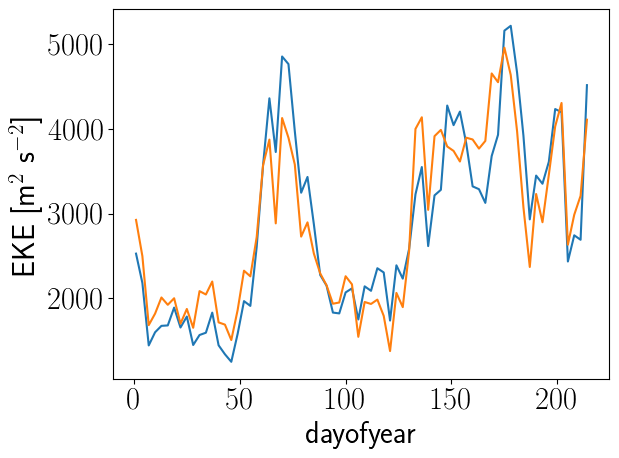

In [129]:
plt.figure()
eke_full_sum.plot()
eke_smth_sum.plot()
plt.ylabel(r'EKE [m$^2$ s$^{-2}$]')
plt.savefig('/homes/metogra/iufarias/Documents/figures/times_series_sum/EKE_sum_timeseries.png')

# Total KE

In [27]:
KE_full=0.5*(uf**2+vf**2).sum(['x_rho','y_rho'])
KE_smth=0.5*(ut**2+vt**2).sum(['x_rho','y_rho'])

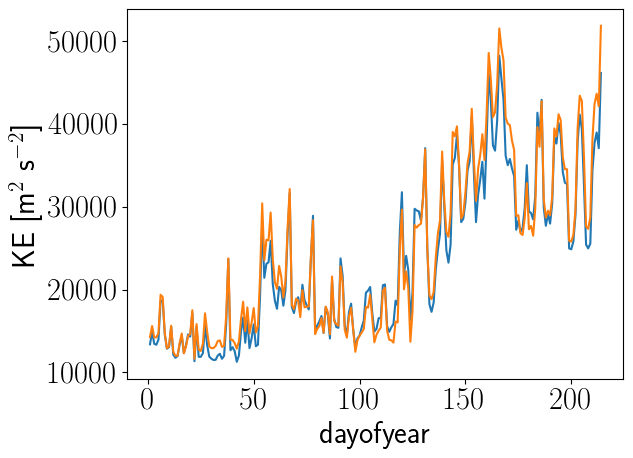

In [138]:
plt.figure()
KE_full.plot()
KE_smth.plot()

plt.ylabel(r'KE [m$^2$ s$^{-2}$]')
plt.savefig('/homes/metogra/iufarias/Documents/figures/times_series_sum/total_KE_sum_timeseries.png')

In [104]:
up_full=uf-uf.mean(axis=0)
vp_full=vf-vf.mean(axis=0)
up_smth=ut-ut.mean(axis=0)
vp_smth=vt-vt.mean(axis=0)

EKEs_full=0.5*(up_full**2+vp_full**2)
EKEs_smth=0.5*(up_smth**2+vp_smth**2)

EKEs_full_sum=0.5*(up_full**2+vp_full**2).sum(['x_rho','y_rho'])
EKEs_smth_sum=0.5*(up_smth**2+vp_smth**2).sum(['x_rho','y_rho'])

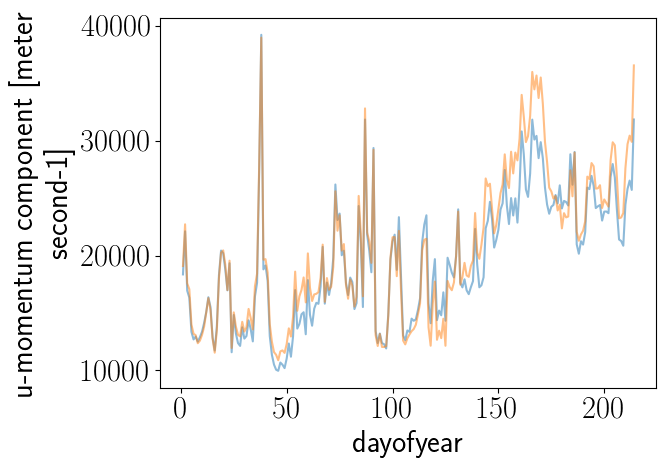

In [34]:
plt.figure()
EKEs_full.plot(alpha=0.5)
EKEs_smth.plot(alpha=0.5)

In [84]:
from scipy.ndimage import gaussian_filter as gauss

In [135]:
%%time
u_full_gauss=gauss(uf.data,100)
v_full_gauss=gauss(vf.data,100)
u_smth_gauss=gauss(ut.data,100)
v_smth_gauss=gauss(vt.data,100)

CPU times: user 13min 19s, sys: 1.18 s, total: 13min 20s
Wall time: 13min 20s


In [136]:
u_full_prime_g=uf-u_full_gauss
v_full_prime_g=vf-v_full_gauss

u_smth_prime_g=ut-u_smth_gauss
v_smth_prime_g=vt-v_smth_gauss

eke_full_g=0.5*(u_full_prime_g**2+v_full_prime_g**2)
eke_smth_g=0.5*(u_smth_prime_g**2+v_smth_prime_g**2)

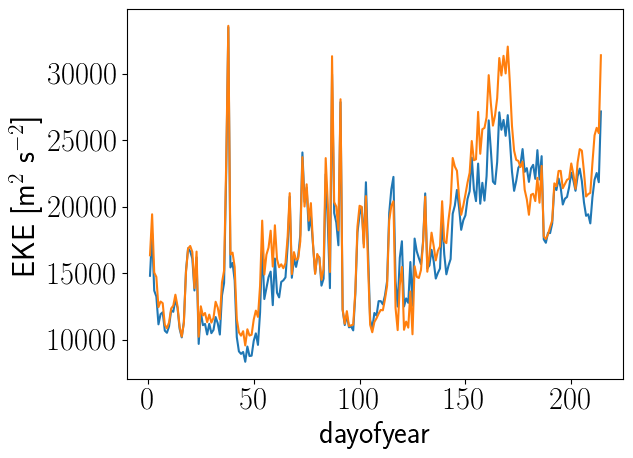

In [137]:
plt.figure()
eke_full_g.sum(['x_rho','y_rho']).plot()
eke_smth_g.sum(['x_rho','y_rho']).plot()
plt.ylabel(r'EKE [m$^2$ s$^{-2}$]')
plt.savefig('/homes/metogra/iufarias/Documents/figures/times_series_sum/EKE_sum_timeseries_gaussian_100.png')

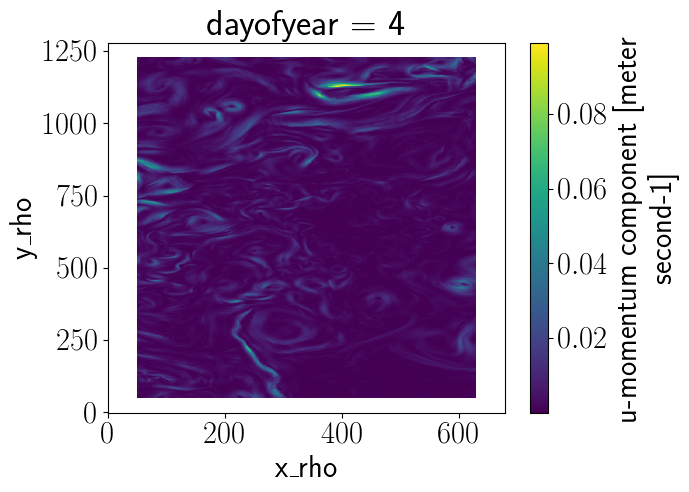

In [133]:
eke_smth[1].plot()

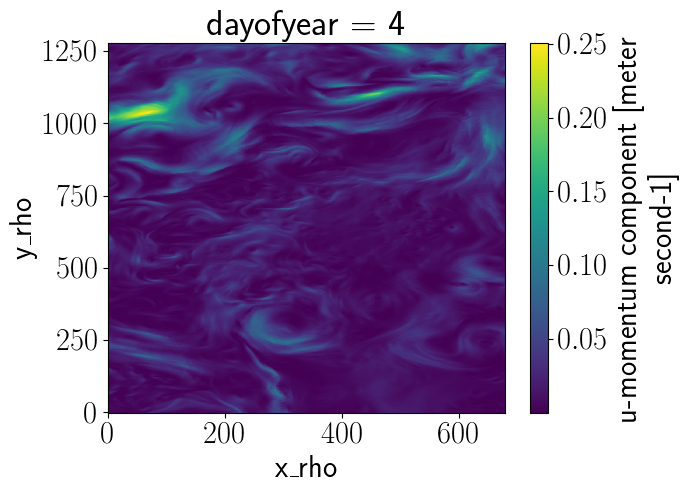

In [130]:
EKEs_smth[3].plot()

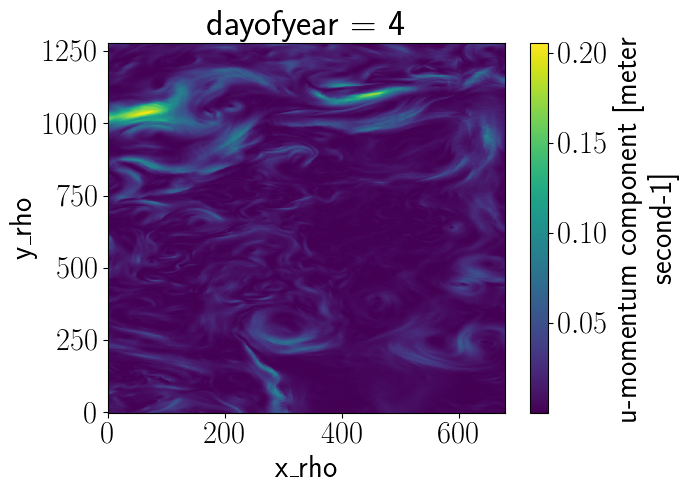

In [131]:
eke_smth_g[3].plot()

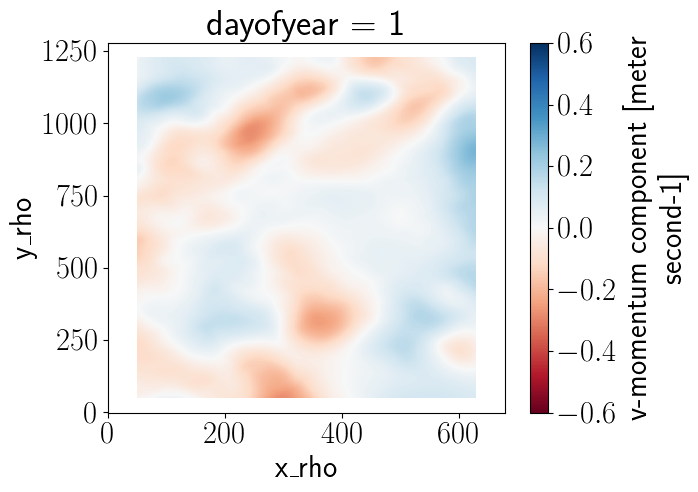

In [124]:
v_sm_smth[0].plot(vmax=0.6,vmin=-0.6,cmap='RdBu')

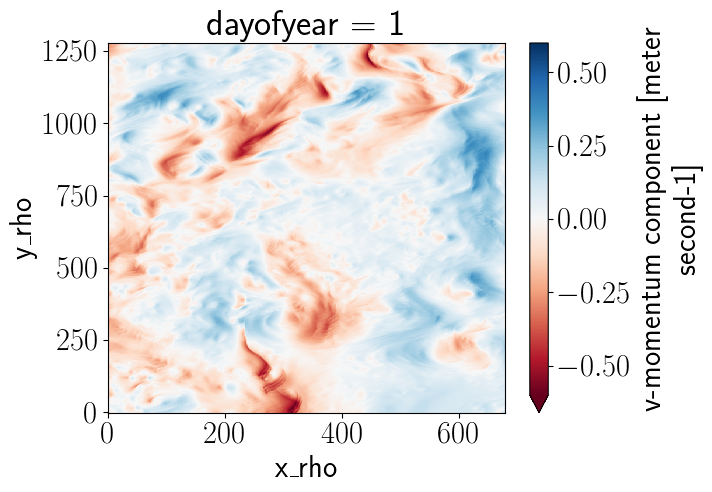

In [123]:
vt[0].plot(vmax=0.6,vmin=-0.6,cmap='RdBu')